<a href="https://colab.research.google.com/github/a-mitani/pyro_code_examples/blob/main/svi-basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Pyroのインストール
!pip install pyro-ppl -q

In [2]:
import random
import numpy as np
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt

In [3]:
# 試行データ作成
def create_data(red_num, white_num):
    red = torch.tensor(1.0)
    white = torch.tensor(0.0)
    data = []
    for _ in range(red_num):
        data.append(red)
    for _ in range(white_num):
        data.append(white)
    random.shuffle(data)
    data = torch.tensor(data)
    return data

data = create_data(7, 3)

In [4]:
# 確率モデルの定義
def model(data):
    # 事前確率分布は無情報、つまりball_ratioが一様分布と仮定する。
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    f = pyro.sample("Theta", dist.Beta(alpha0, beta0))

    # 観測データのプレート定義
    with pyro.plate('observation'):
      pyro.sample('X', dist.Bernoulli(f), obs=data)

In [5]:
def guide(data):
    # 変分パラメータαとβを定義する。
    # 初期値は共に10としている。
    # また、ベータ分布においてこれらのパラメータは正の値なので`constraints.positive`を指定。
    alpha_q = pyro.param("alpha_q", torch.tensor(10.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(10.0),
                        constraint=constraints.positive)
    # 最適化されたパラメータのベータ分布から混合率Θをサンプリングする
    pyro.sample("Theta", dist.Beta(alpha_q, beta_q))

##################################################

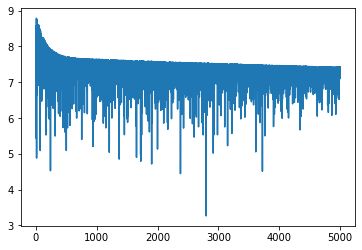

In [6]:
# グローバル変数として保存されているパラメータを削除
pyro.clear_param_store()

# Optimizerの定義と設定（Adamの利用が推奨されている）
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

# 推論アルゴリズムとLoss値を定義
# ここでは組み込みのELBOの符号反転をLoss値とする`Trace_ELBO()`を利用しています。
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# 最適化の逐次計算
# ここではAdamで勾配降下を5000回繰り返すことになる。
n_steps = 5000
losses = []
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 100 == 0:
        print('#', end='')

plt.plot(losses)

In [7]:
# 最適化後の変分パラメータを取得する
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()
print("alpha_q = {:.2f}, beta_q = {:.2f}".format(alpha_q, beta_q))

alpha_q = 12.94, beta_q = 6.08


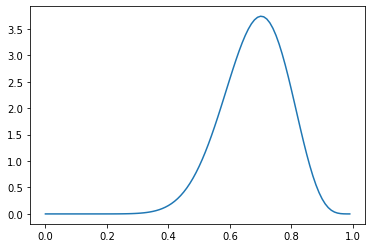

In [8]:
# 得られたパラメータを用いて事後確率分布をプロット
x_range = np.arange(0.0, 1.0, 0.01)
estimated_dist = dist.Beta(alpha_q, beta_q)
y = [estimated_dist.log_prob(torch.tensor([x])).exp() for x in x_range]
plt.plot(x_range, y)